In [1]:
import os
import shutil
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib.ticker import MaxNLocator

In [2]:
def fluorescence_extract(working_dir, 
                        results_folder = "results", 
                        trial_name = "Neuron", 
                        position_t=100, 
                        background_averages=[[1]]):
    
    os.chdir(working_dir)
    output_path = os.path.join(working_dir, 'python_files')
    
    if os.path.exists(output_path):
        shutil.rmtree(output_path)
    
    os.mkdir('python_files')
    
    position_t_column = np.arange(0,position_t)
    position_t_array = pd.DataFrame(position_t_column, columns = ['POSITION_T'])
    
    POSITION_T_path = os.path.join(output_path, "POSITION_T.csv")
    position_t_array.to_csv(POSITION_T_path,index=False)
    
    for filename in os.listdir(working_dir):
        if filename.endswith(".csv"): 
            df = pd.read_csv(filename, usecols=(["POSITION_T","MEAN_INTENSITY"]))
            file_name = os.path.splitext(filename)[0]
            df.columns = ['POSITION_T', file_name]
            df.to_csv(f"python_files/{file_name}py.csv",index=False, na_rep = '')
            
    for filename in os.listdir(output_path):
        if filename.endswith("py.csv"):
            POSITION_T = pd.read_csv(POSITION_T_path, na_values = '')
            data = os.path.join(output_path, filename)
            df = pd.read_csv(data)
            joined = POSITION_T.merge(df, on = "POSITION_T", how='left')
            joined.to_csv(POSITION_T_path,index=False, na_rep = '')
            os.remove(data)
    
    subtract_averages = pd.read_csv(POSITION_T_path, na_values = '')
    subtract_averages_sort = subtract_averages.reindex(sorted(subtract_averages.columns), axis=1)
    
    cols = list(subtract_averages_sort.columns)
    cols = [cols[-1]] + cols[:-1]
    subtract_averages = subtract_averages_sort[cols]
    
    Averages = [0]
    for i in background_averages:
        Averages.append(i)

    subtract_averages = subtract_averages - Averages
    subtract_averages.to_csv(f"python_files/{trial_name}_subtracted_averages.csv",index=False, na_rep = "")

    max_value = subtract_averages.drop('POSITION_T', 1)
    max_value = max_value.max(axis=1)
    subtract_averages['max_value'] = max_value
    subtract_averages.to_csv(f"python_files/{trial_name}_max_value.csv",index=False, na_rep = "")

    
    first_neuron_POSITION_T = subtract_averages['max_value'].first_valid_index()
    Fo = max_value[first_neuron_POSITION_T]
    dF = (max_value-Fo)/Fo
    subtract_averages['dF/F0'] = dF
    file_name = os.path.splitext(filename)[0]
 
    subtract_averages.to_csv(f"python_files/{trial_name}_dF_F0.csv",index=False, na_rep = "")
    
   
    if results_folder == "results":
        new_path = os.path.dirname(working_dir)
        try:
            os.mkdir(f"{new_path}/{results_folder}")
        except:
            pass
        results_folder = f"{new_path}/{results_folder}"
        
    else:
        
        try:
            os.mkdir(results_folder)
            print("Created: " + results_folder)
        except:
            print('Results folder exists')
        
    subtract_averages.to_csv(f"{results_folder}/{trial_name}.csv",index=False, na_rep = "")
    
    average_plot = subtract_averages.plot.line(x="POSITION_T", y="dF/F0", legend=False, title = trial_name)
    average_plot.set_xlabel("Position T")
    average_plot.set_ylabel("\u0394F/F0")
    average_plot.xaxis.set_major_locator(MaxNLocator(integer=True))
    
    try:
        os.mkdir(f"{results_folder}/Neuron Plots")
    except:
        pass
                 
    plt.savefig(f"{results_folder}/Neuron Plots/{trial_name}.png", bbox_inches = "tight")
    
def loop_fluorescence_extract(working_dir, 
                              background_file, 
                              number_of_position_t = 100,
                              result_folder = "results", 
                              ):

    background_file = pd.read_csv(background_file, keep_default_na = False)
    number_of_neurons = len(background_file.columns)
    
    background_averages_list = []
    
    for i in range(0,number_of_neurons):
        column_name = f"Neuron {i}"
        list1 = background_file.loc[~background_file[column_name].astype(str).str.isdigit(), column_name].tolist()
        list2 = []
        for x in list1:
            try:
                float_list = float(x)
                list2.append(float_list)
            except:
                pass
        background_averages_list.append(list2)

    for i in range(0, number_of_neurons):
        fluorescence_extract(f'{working_dir}/Neuron {i}',
                             trial_name = f"Neuron {i}",
                             position_t = number_of_position_t,
                             background_averages= background_averages_list[i],
                             results_folder = result_folder )

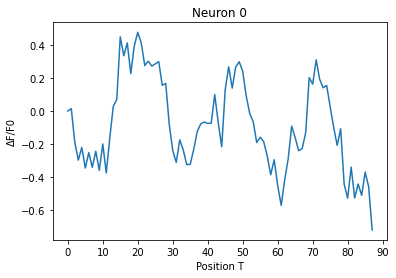

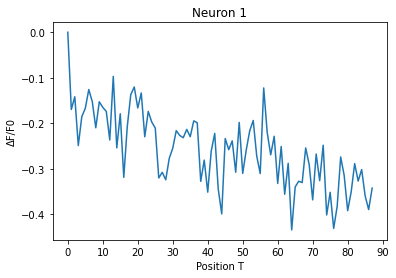

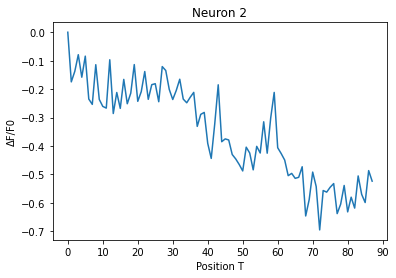

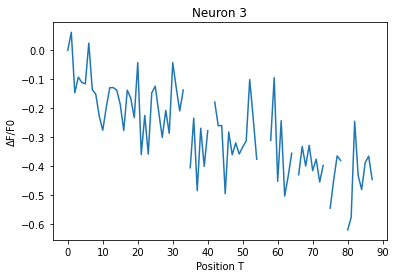

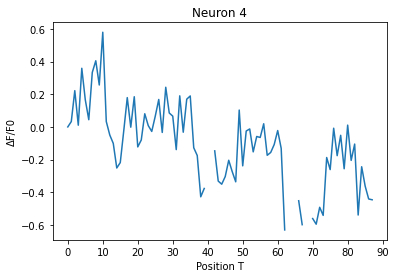

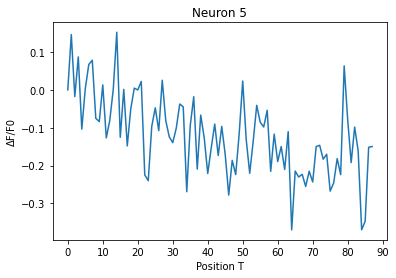

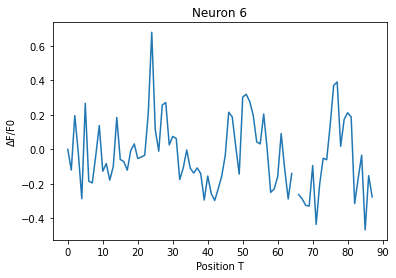

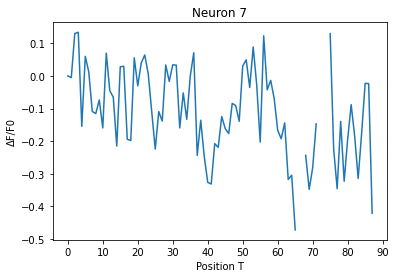

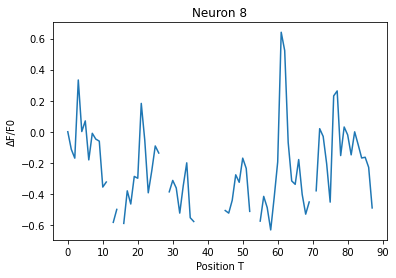

In [4]:
loop_fluorescence_extract(r'/Users/alisasmacbook/Desktop/Ir25a_KO', 
                          background_file =  r'/Users/alisasmacbook/Desktop/Ir25a_KO/Background_list.csv',
                          number_of_position_t = 88
                         )